# LIBRARIES

In [1]:
import pickle
from Environment import Environment
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from ucb1_brute_force import *
from ucb1_greedy import *

# ENVIRONMENT DEFINITION 

In [2]:
np.random.seed(1)

users = []
products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]

prices = [[5, 6, 7, 8],
          [13., 16, 19, 22],
          [20., 24, 27, 31],
          [30., 33, 36, 39],
          [38., 42, 46, 49]]
#1-2 di delta, Con sovrapposizione

cost = [1.3, 1.8, 2.1, 3.5, 6]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente

cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2

secondary_dict={           # Propongo i prodotti più simili a quello mostrato --> problemino: 2 viene mostrato quasi sempre
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}

#Secondary_dict={           # Propongo i prodotti più simili a quello mostrato --> problemino: 2 viene mostrato quasi sempre
#    "Calabazas": [1,4],
#    "Hinojo": [2,0],
#    "Sesamo": [0,3],
#    "Girasol": [4,1],
#    "Amapola": [3,2]
#}

res_price_params = {
    "mean": 24, 
    "std": 12
}


probabilities = [[0, 0.6, 0.3, 0, 0],
                 [0.4, 0, 0.5, 0, 0],
                 [0, 0.5, 0, 0.5, 0],
                 [0, 0, 0.6, 0, 0.5],
                 [0, 0, 0.3, 0.5, 0]]
probabilities = np.matrix(probabilities)


alphas=[10, 10, 10, 10, 10] 
# per ora li generiamo così, tutti uguali -> devo generare 3 diversi vettori alpha

poisson_lambda = 3
#=valore atteso del numero di prodotti acquistati (specifico per prodotto)...non dipende dal
#prodotto oltre che dallo user che dal tipo di user che

# p_users = [4/9, 3/9, 2/9] #probabilità di essere un tipo di utente-> da cambiare
p_users = [1]

lambda_q = 0.7 #just my idea of lambda
#possiamo stimarlo con i dati passati provenienti dal sito -> vino tot è stato comprato 15 volte

#proviamo a pensare, ha senso vederlo come coppia? categoria-prodotto? Avrei 3 categorie *5 prodotti-> 15 lambda diversi
# ^^ Andre: secondo me ha senso avere 3 lambda_q diversi per categoria MA non per prodotto. La probabilità di continuare
#           a guardare secondo me dipende dall'utente e non dal prodotto

for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# for i in range(3):
users.append(UserCat(alphas, res_price_params, poisson_lambda, probabilities))

env = Environment(users, products,  lambda_q, secondary_dict, p_users)

In [3]:
env.optimal_reward()

(53.24198528630221, [3, 2, 0, 0, 0])

In [4]:
a = env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"])
a

{'CR_vector': array([[636., 649., 494., 195., 103.],
        [674., 734., 657., 443., 679.]]),
 'alpha_ratios': array([0.275 , 0.131 , 0.1575, 0.1255, 0.311 ]),
 'n_prod_sold': array([3.91031588, 3.99685675, 3.89668225, 3.97415517, 4.22289098]),
 'graph_weights': array([[0.        , 0.61131619, 0.20203669, 0.        , 0.        ],
        [0.34928594, 0.        , 0.34248747, 0.        , 0.        ],
        [0.        , 0.48622366, 0.        , 0.37874414, 0.        ],
        [0.        , 0.        , 0.54540496, 0.        , 0.35622774],
        [0.        , 0.        , 0.25298157, 0.39431066, 0.        ]])}

# Greedy Algorithm Example

In [5]:
greedy_optimizer = Greedy_optimizer(env)
greedy_optimizer.run()

{'combination': [3, 2, 0, 0, 0], 'expected_reward': 53.24198528630221}

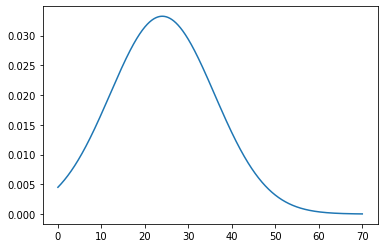

In [7]:
res_price_distr = env.users[0].norm
x = np.arange(0, 70 , .01)
y = res_price_distr.pdf(x)
plt.figure(0)
plt.plot(x, y)
plt.show()

# STEP 3 : Uncertain Convertion Rates

In [6]:
from step3_learner import TS_learner3

In [7]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = TS_learner3(initial_beta, env, learning_rate = 0.2)

In [8]:
n_runs = 1
daily_users = 200
n_days = 300

# delete possible old reward_history
learner.reward_history = []
learner.price_comb_history = []

learner.run(n_days, daily_users)

for i in range(n_runs) :
    learner.run(n_days, daily_users)

opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ## Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [23]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ## Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [13]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ## Cumulative Regret Plot

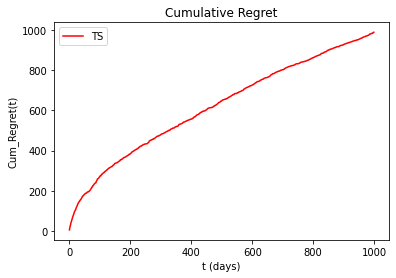

In [9]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ## Standard Deviation Plot

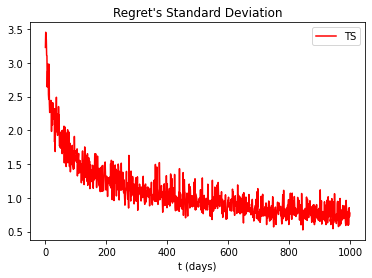

In [26]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

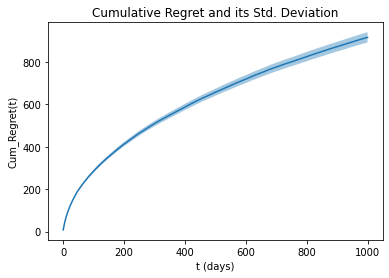

In [27]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ## Comparison between Optimal and Expected Reward

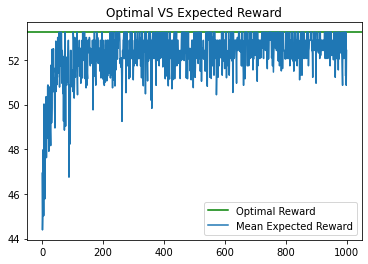

In [10]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## Explore the istant regret in the collected runs of the step 3 learner

In [11]:
opt_reward = learner.opt_reward
(opt_reward - collected_rewards)[0][-40:]

array([0.        , 0.        , 2.40679173, 0.        , 0.71983174,
       0.71983174, 0.        , 0.71983174, 0.71983174, 0.        ,
       0.        , 0.71983174, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.71983174, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.71983174,
       3.57100409, 0.71983174, 0.        , 0.        , 0.        ,
       0.71983174, 0.        , 0.        , 0.        , 0.        ,
       0.        , 2.28410696, 0.        , 2.46393778, 0.        ])

In [13]:
learner.price_comb

[[3, 2, 0, 0, 0], [1, 2, 0, 0, 0]]

## Comparison between mean conversion rates estimated by last run of TS and real values

In [29]:
A = learner.beta_parameters[0]
B = learner.beta_parameters[1]
mean_cr = A/(A+B)
mean_cr

array([[0.5       , 0.95292159, 0.93139842, 0.93717983],
       [0.88391699, 0.80452789, 0.7565531 , 0.66669563],
       [0.75603263, 0.62283627, 0.54292624, 0.40714286],
       [0.38717628, 0.28688047, 0.20143885, 0.18072289],
       [0.16065849, 0.0875    , 0.05970149, 0.09259259]])

In [18]:
np.matrix(env.theoretical_values['conversion_rates'][0])

matrix([[0.94332725, 0.9331928 , 0.9217098 , 0.90878878],
        [0.82034133, 0.74750746, 0.66153888, 0.56618383],
        [0.63055866, 0.5       , 0.40129367, 0.27983446],
        [0.30853754, 0.22662735, 0.15865525, 0.10564977],
        [0.1216725 , 0.0668072 , 0.03337651, 0.01861043]])

In [19]:
env.optimal_reward()

(53.24198528630221, [3, 2, 0, 0, 0])

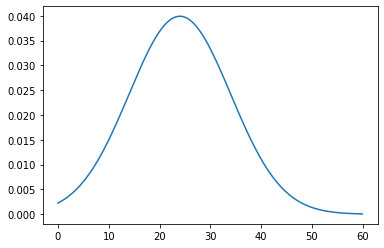

0.5

In [57]:
norm = scipy.stats.norm(loc = 24, scale = 10)
x = np.arange(0, 60, 0.1)
y = norm.pdf(x)
plt.plot(x, y)
plt.show()
norm.cdf(24)

- ### ucb1 (with greedy optimizer)

In [30]:
ucb1_greedy_R = []
ucb1g_collected_rewards = []
for _ in range(n_runs):
    ucb_greedy = ucb1_greedy(len(prices), len(prices[0]), prices, env)
    instant_regret = []
    ucb1g_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_greedy.pull_arms()
        estimated_CR = env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_greedy.update(pulled_arms, estimated_CR)
        reward = env.expected_reward(pulled_arms)
        ucb1g_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1g_collected_rewards.append(ucb1g_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_greedy_R.append(cumulative_regret)

NameError: name 'env' is not defined

In [ ]:
# store the result
with open("ucb1_greedy_R", 'wb') as f1:
    pickle.dump(ucb1_greedy_R, f1)
with open("ucb1g_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1g_collected_rewards, f1)

In [24]:
# load the result
with open("ucb1_greedy_R", 'rb') as f1:
    ucb1_greedy_R = pickle.load(f1)
with open("ucb1g_collected_rewards", 'rb') as f1:
    ucb1g_collected_rewards = pickle.load(f1)

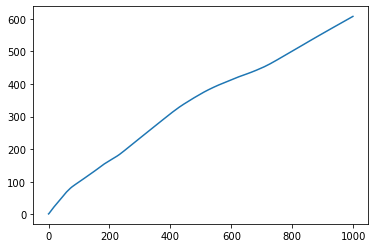

In [25]:
# plot of the result
mean_ucbg_R = np.mean(ucb1_greedy_R, axis=0)
std_dev_ucbg = np.std(ucb1_greedy_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbg_R)
plt.fill_between(range(n_days), mean_ucbg_R-std_dev_ucbg, mean_ucbg_R+std_dev_ucbg, alpha=0.4)

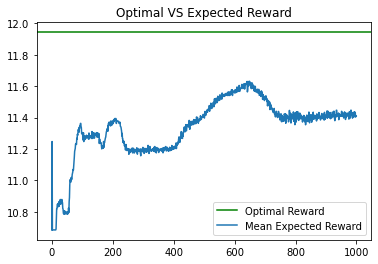

In [26]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1g_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### ucb1 (brute force approach)

In [ ]:
n_runs = 2

ucb1_bforce_R = []
ucb1bf_collected_rewards = []
for _ in range(n_runs):
    ucb_brute_force = ucb1_brute_force(len(prices), len(prices[0]), prices, env)
    instant_regret = []
    ucb1bf_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_brute_force.pull_arms()
        estimated_CR = env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_brute_force.update(pulled_arms, estimated_CR)
        reward = env.expected_reward(pulled_arms)
        ucb1bf_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1bf_collected_rewards.append(ucb1bf_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_bforce_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_bforce_R", 'wb') as f1:
    pickle.dump(ucb1_bforce_R, f1)
with open("ucb1bf_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1bf_collected_rewards, f1)

In [27]:
# load the result
with open("ucb1_bforce_R", 'rb') as f1:
    ucb1_bforce_R = pickle.load(f1)
with open("ucb1bf_collected_rewards", 'rb') as f1:
    ucb1bf_collected_rewards = pickle.load(f1)

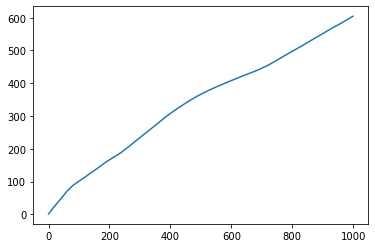

In [28]:
# plot of the result
mean_ucbbf_R = np.mean(ucb1_bforce_R, axis=0)
std_dev_ucbbf = np.std(ucb1_bforce_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbbf_R)
plt.fill_between(range(n_days), mean_ucbbf_R-std_dev_ucbbf, mean_ucbbf_R+std_dev_ucbbf, alpha=0.4)

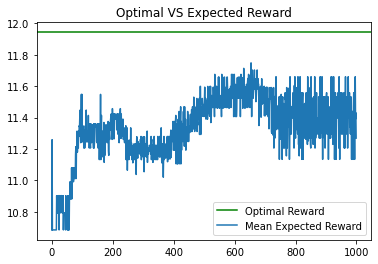

In [29]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1bf_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()